In [22]:
import random
from pprint import pprint

import numpy as np
import scipy.optimize
import scipy.stats

import matplotlib.pyplot as plt

# Helper functions

In [23]:
# OUTPUTS:
# 1. universe = list of all players, i.e. [1, ..., n]
# 2. pi_list = list of all partial rankings. each partial ranking is tuple (ordering, scores)
# e.g. ([1,3,2],[5,6,7]) means player 1 < player 3 < player 2, with player 1 getting score 5, etc.

# INPUTS:
# 1. n = size of universe
# 2. s is such that
# partial rankings = min(s, #of partial rankings needed so that each element of the universe is in >1 ranking)
# 3. p = prob an element is in s 
# 4. means[i] is mean score for elt i
# 5. sigma = stdev of scores
def create_pi_list(n, s, p, means, sigma):
    pi_list = []
    included_elts = set() # list of all elements in some partial ranking
    while (len(included_elts) < n) or (len(pi_list) < s):
        pi=[]
        for v in range(1, n+1):
            if random.uniform(0,1) < p:
                pi += [v]
        scaling = np.random.uniform(low=1/3,high=3)
        scores = [np.random.normal(means[w-1] / 5, sigma) * scaling for w in pi]

        if len(pi) > 1:
            scores_sorted = [x for x, _ in sorted(zip(scores, pi), key=lambda pair: pair[0])]
            pi_sorted = [x for _, x in sorted(zip(scores, pi), key=lambda pair: pair[0])]
            pi_list += [(pi_sorted, scores_sorted)]
            included_elts.update(pi_sorted)
    universe=np.array(list(included_elts))
    return (universe, pi_list)

In [24]:
##################################################
# COMPUTE PAGERANK
##################################################

# given probability transition matrix P
# where P_{v,w} = Prob(w -> v)
# find pagerank scores with restart probability r
def compute_pr(P, r, n, eps=1e-8):
    x = np.ones(n) / n*1.0
    flag = True
    t=0
    while flag:
        x_new = (1-r)*P.dot(x)
        x_new = x_new + np.ones(n) * r / n
        diff = np.linalg.norm(x_new - x)
        if np.linalg.norm(x_new - x,ord=1) < eps and t > 100:
            flag = False
        t=t+1
        x = x_new
    return x

# Hypergraph ranking

In [ ]:
# OUTPUT:
# ordering of players using hypergraph rank aggregation algorithm
# expressed via a list, e.g. [1,3,2,4] means player 1 < player 3 < ...
def hg_rank(universe, pi_list):
    # first create these matrices
    # R = |E| x |V|, H(e, v) = lambda_e(v)
    # W = |V| x |E|, W(v, e) = w(e) 1(v in e)
    m = len(pi_list) # number of hyperedges
    n = len(universe) # number of items to be ranked 
    R = np.zeros([m, n])
    W = np.zeros([n, m])

    for i in range(len(pi_list)):
        pi, scores = pi_list[i]
        if len(pi) > 1:   
            for j in range(len(pi)):
                v = pi[j]
                v = np.where(universe == v)[0][0] #equivalent to universe.index(v) but for np arrays
                R[i, v] = np.exp(scores[j])
                W[v, i] = 1.0

            # edge weight is stdev of vertex weights
            W[:, i] = (np.std(scores) + 1.0) * W[:, i]

            R[i, :] = R[i,:] / sum(R[i,:])

    # create diagonal matrix with entries d(v)
    D_V = np.diag(np.sum(W, 1))

    # create prob trans matrix
    P = np.linalg.inv(D_V).dot(W).dot(R)
    P = np.transpose(P) # since we're using column vectors
    print('shape of P:', np.shape(P))
    # create RWR matrix
    r=0.40
    rankings = compute_pr(P, r, n)
    print('shape of rankings:', np.shape(rankings))
    return universe[np.argsort(rankings)]

# Clique graph ranking

In [26]:
# Create matrix A, where A_{u,v} is given in Eq 10 in main text
def compute_gh_weights(R, W):
    E, V = R.shape
    A = np.zeros([V,V]) # to return
    
    # first, create edge weight vector
    WE = np.zeros(E)
    # for each edge, find first non-zero value that is >0
    for e in range(E):
        WE[e] = W[np.where(W[:,e] > 0)[0],e][0]
    
    # iterate over edges, add w(e) * gam_e(u) * gam_e(v) term
    # for each pair of vertices u,v \in e
    for e in range(E):
        nodes_in_e = np.nonzero(R[e,:])[0]
        for u in nodes_in_e:
            for v in nodes_in_e:
                A[u,v] += WE[e] * R[e,u] * R[e,v]
    return A

In [27]:
# OUTPUT:
# ordering of players using hypergraph rank aggregation algorithm
# expressed via a list, e.g. [1,3,2,4] means player 1 < player 3 < ...
def gh_rank(universe, pi_list):
    # first create these matrices
    # R = |E| x |V|, H(e, v) = lambda_e(v)
    # W = |V| x |E|, W(v, e) = w(e) 1(v in e)
    m = len(pi_list) # number of hyperedges
    n = len(universe) # number of items to be ranked 
    R = np.zeros([m, n])
    W = np.zeros([n, m])

    for i in range(len(pi_list)):
        pi, scores = pi_list[i]
        if len(pi) > 1:   
            for j in range(len(pi)):
                v = pi[j]
                v = np.where(universe == v)[0][0] #equivalent to universe.index(v) but for np arrays
                R[i, v] = np.exp(scores[j])
                W[v, i] = 1.0

            # edge weight is stdev of vertex weights?
            W[:, i] = (np.std(scores) + 1.0) * W[:, i]

            R[i, :] = R[i,:] / sum(R[i,:])

    # compute edge weights of G^H
    A = compute_gh_weights(R, W)
            
    # create prob trans matrix by normalizing columns to sum to 1
    P = A/A.sum(axis=1)[:,None]
    P=P.T

    # create RWR matrix
    r=0.40
    rankings = compute_pr(P, r, n)
    return universe[np.argsort(rankings)]

# MC3 ranking

In [28]:
# OUTPUT:
# ordering of players using hypergraph rank aggregation algorithm
# expressed via a list, e.g. [1,3,2,4] means player 1 < player 3 < ...
def dwork_mc3_rank(universe, pi_list):

    n = len(universe)

    P = np.zeros([n, n]) #Pij = prob i -> j
    # print('pi list')
    # print([p[0] for p in pi_list])
    # print('')
    for i in universe:
        # print('i: ' + str(i))
        i_counts = np.zeros(n)
        i_deg = 0 #number of hyperedges where i can traverse to some other vertex

        i_index = np.where(universe == i)
        for pi, scores in pi_list:
            if i in pi and len(pi) > 1:
                pi_filtered = pi[pi.index(i)+1:] #everything ranked better than i

                # if i can use this hyperedge
                if len(pi_filtered) > 0:
                    # essentially, for each j in pi_filtered
                    # grab k=universe.index(j) and increment i_counts[k] by 1/len(pi)
                    i_counts[np.where(np.isin(universe, pi_filtered))] += 1/len(pi)

                i_counts[i_index] += 1 - (len(pi_filtered) / len(pi))
                i_deg += 1
        if i_deg > 0:
            i_counts /= i_deg
        else:
            i_counts[i_index] = 1
        P[i_index,:] = i_counts

    P = np.transpose(P) # since we're using column vectors

    # create RWR matrix
    r=0.40
    rankings = compute_pr(P, r, n)
    return universe[np.argsort(rankings)]

# Run simulations

In [ ]:
sigma_list=[1]
p_list = [0.03, 0.05, 0.07]
num_trials = 10 #number of trials for each (sigma, p) pair
n = 100 #number of elements to collectively rank

def ranking(n, rank_agg_fns, names, sigma_list, p_list, num_trials):
    sl = len(sigma_list)
    pl = len(p_list)

    wkt_means_hg = np.zeros([sl, pl])
    wkt_stdevs_hg = np.zeros([sl, pl])
    
    wkt_means_gh = np.zeros([sl, pl])
    wkt_stdevs_gh = np.zeros([sl, pl])
    
    wkt_means_dwork = np.zeros([sl, pl])
    wkt_stdevs_dwork = np.zeros([sl, pl])

    for ind1 in range(len(sigma_list)):
        for ind2 in range(len(p_list)):
            sigma = sigma_list[ind1]
            p = p_list[ind2]
            # store results of trials
            hg_wkt_list = np.zeros([num_trials])
            gh_wkt_list = np.zeros([num_trials])
            dwork_wkt_list = np.zeros([num_trials])
            
            for k in range(num_trials):
                # give each element a mean score from [0, 10]
                means = np.zeros([n])
                for i in range(n):
                    means[i] = i

                # create partial rankings
                # for each elt, create 2 partial rankings with that elt?
                # ill start with 1
                universe, pi_list = create_pi_list(n, n, p, means, sigma) #middle is s, currently using s=n
                # true ranking
                # lol the -1 bc i still want to use 1-indexing
                true_ranking = [x for _, x in sorted(zip(means[universe - 1], universe), key=lambda pair: pair[0])]
                # compute ranking for HG
                hg_ranking = hg_rank(universe, pi_list)
                hg_wkt_dist = scipy.stats.weightedtau(hg_ranking, true_ranking).correlation
                hg_wkt_list[k] = hg_wkt_dist
                
                # compute ranking for G^H
                gh_ranking = gh_rank(universe, pi_list)
                gh_wkt_dist = scipy.stats.weightedtau(gh_ranking, true_ranking).correlation
                gh_wkt_list[k] = gh_wkt_dist
                
                # compute ranking for dwork
                dwork_ranking = dwork_mc3_rank(universe, pi_list)
                dwork_wkt_dist = scipy.stats.weightedtau(dwork_ranking, true_ranking).correlation
                dwork_wkt_list[k] = dwork_wkt_dist
            
            # compute mean, stdev for each fn and add to kt_means, kt_stdevs [and wkt variants]
            wkt_means_hg[ind1, ind2] = np.mean(hg_wkt_list)
            wkt_stdevs_hg[ind1, ind2] = np.std(hg_wkt_list)
            
            wkt_means_gh[ind1, ind2] = np.mean(gh_wkt_list)
            wkt_stdevs_gh[ind1, ind2] = np.std(gh_wkt_list)
            
            wkt_means_dwork[ind1, ind2] = np.mean(dwork_wkt_list)
            wkt_stdevs_dwork[ind1, ind2] = np.std(dwork_wkt_list)

    return wkt_means_hg, wkt_stdevs_hg, wkt_means_gh, wkt_stdevs_gh, wkt_means_dwork, wkt_stdevs_dwork
# Example usage
rank_agg_fns = [gh_rank, hg_rank]
names = ["gh", "hg"]
wkt_means_hg, wkt_stdevs_hg, wkt_means_gh, wkt_stdevs_gh, wkt_means_dwork, wkt_stdevs_dwork = ranking(n, rank_agg_fns, names, sigma_list, p_list, num_trials)

print(wkt_means_hg)
print(wkt_means_dwork)
print(wkt_means_gh)

shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape of hg_ranking: (100,)
shape of true_ranking: (100,)
shape of P: (100, 100)
shape

# Plot results

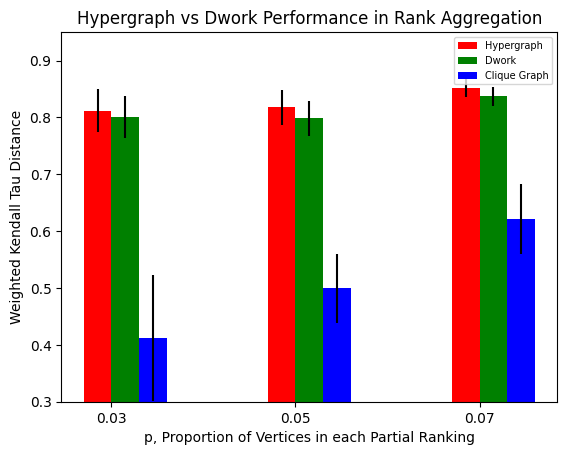

In [30]:
ind = np.arange(3)  # the x locations for the groups
width = 0.15       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, wkt_means_hg[0,:], width, color='r', yerr=wkt_stdevs_hg[0,:])
rects2 = ax.bar(ind + width, wkt_means_dwork[0,:], width, color='g', yerr=wkt_stdevs_hg[0,:])
rects3 = ax.bar(ind + 2*width, wkt_means_gh[0,:], width, color='b', yerr=wkt_stdevs_gh[0,:])

# add some text for labels, title and axes ticks
ax.set_xlabel('p, Proportion of Vertices in each Partial Ranking')
ax.set_ylabel('Weighted Kendall Tau Distance')
ax.set_title('Hypergraph vs Dwork Performance in Rank Aggregation')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('0.03', '0.05', '0.07'))
ax.set_ylim(bottom=0.3,top=0.95)

ax.legend((rects1[0], rects2[0], rects3[0]), ('Hypergraph', 'Dwork', 'Clique Graph'), prop=dict(size=7), loc='best')
plt.savefig('hg_dwork_clique_sigma_1.pdf')